In [1]:
import numpy as np
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import urllib
import pyaudio
import wave

# Lire des données depuis un fichier son

In [3]:
url = 'http://www.nch.com.au/acm/11k16bitpcm.wav'
tmp_file,_ = urllib.urlretrieve (url)
tmp_file

'/tmp/tmpqb8HKR.wav'

In [4]:
wf = wave.open(tmp_file, 'rb')
wf

<wave.Wave_read instance at 0x7fa2ba02ab90>

In [5]:
p = pyaudio.PyAudio()
stream = p.open(format=p.get_format_from_width(wf.getsampwidth()),
                channels=wf.getnchannels(),
                rate=wf.getframerate(),
                output=True)

data = wf.readframes(-1)
stream.write(data)

stream.stop_stream()
stream.close()


In [6]:
print(type(data),len(data))
npdata = np.fromstring(data, dtype=np.int16)

(<type 'str'>, 304534)


In [7]:
npdata.shape

(152267,)

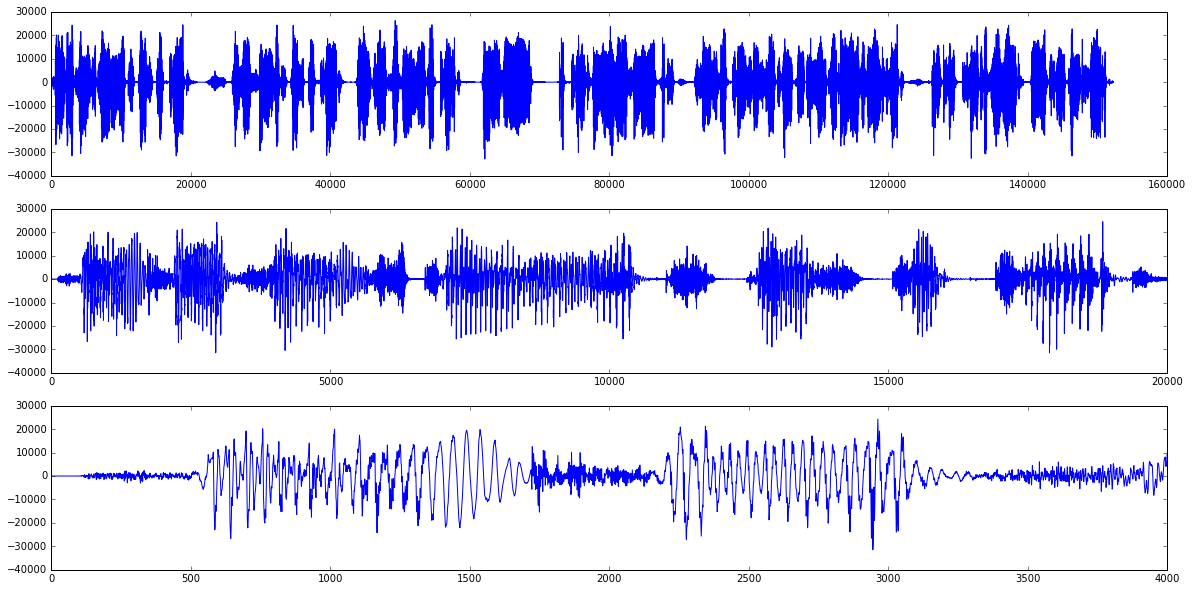

In [8]:
plt.figure(figsize=[20,10])
plt.subplot(3,1,1)
plt.plot(npdata)
plt.subplot(3,1,2)
plt.plot(npdata[:20000])
plt.subplot(3,1,3)
plt.plot(npdata[:4000])


In [9]:
stream = p.open(format=p.get_format_from_width(wf.getsampwidth()),
                channels=wf.getnchannels(),
                rate=wf.getframerate(),
                output=True)

interval = {'thank':[500,2000],'you':[2000,3500]}

def out(stream,npdata):
        stream.write(npdata.tostring())

In [10]:
word = 'thank'
out(stream,npdata[interval[word][0]:interval[word][1]])

In [11]:
word = 'you'
out(stream,npdata[interval[word][0]:interval[word][1]])

# split

In [12]:
from scipy.signal import convolve

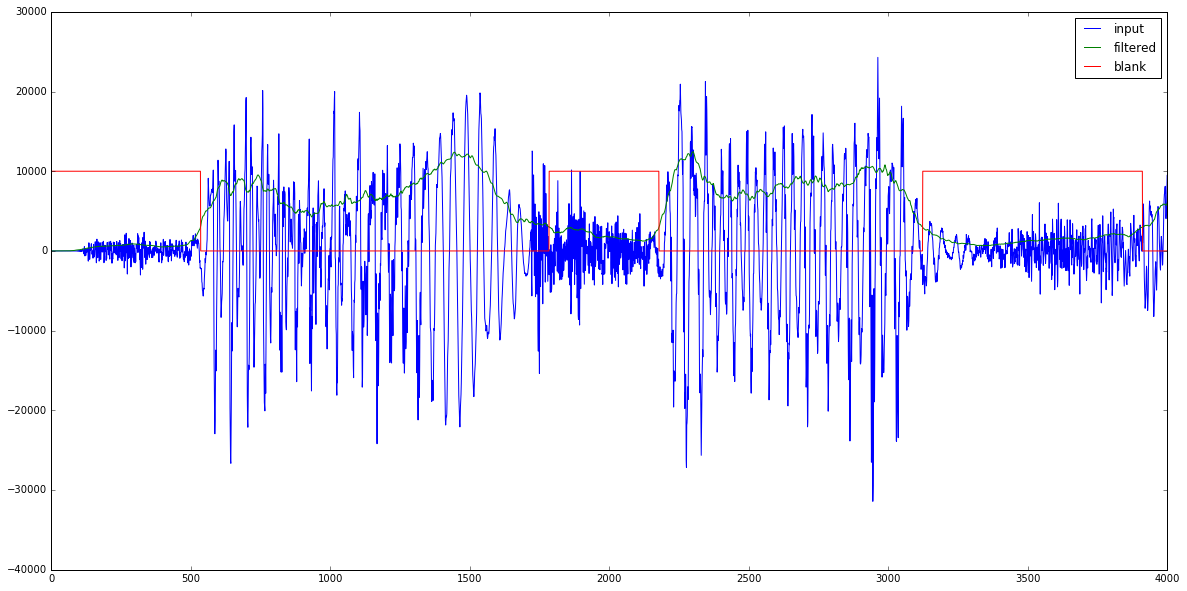

In [13]:
# filtrage par convolution
w = 100
lp = convolve(np.abs(npdata),np.ones(w)/w,mode='same')

# détection des 'blancs'
th = lp<3000

plt.figure(figsize=[20,10])
plt.plot(npdata[:4000],label='input')
plt.plot(lp[:4000],label='filtered')
plt.plot(th[:4000]*10000,label='blank')
plt.legend();

# silencing

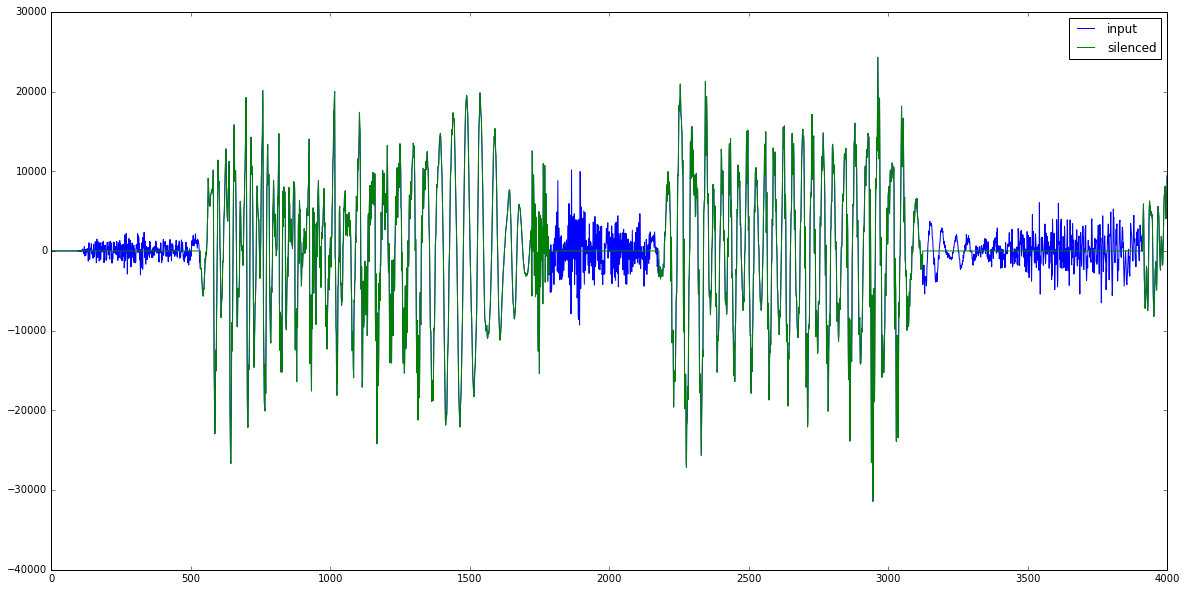

In [14]:
silenced = npdata.copy()
silenced[th] = 0

plt.figure(figsize=[20,10])
plt.plot(npdata[:4000],label='input')
plt.plot(silenced[:4000],label='silenced')
plt.legend();

In [15]:
out(stream,silenced)

# split words

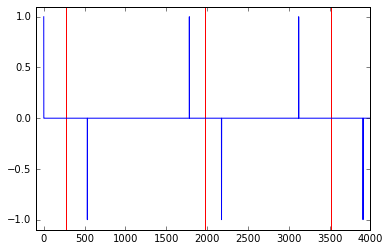

In [16]:
# milieu des intervals
th[0] = 0 # force le début du premier blanc
dth = np.diff(th*1)

i_up = np.where(dth>0)[0]
i_down = np.where(dth<0)[0]

mid_blanks = [(start+stop)/2 for start,stop in zip(i_up,i_down)]

plt.plot(dth[:4000])
plt.gca().set_ylim(-1.1,1.1)
plt.gca().set_xlim(-100)
ax = plt.gca()
ax.vlines(mid_blanks, 0, 1, transform=ax.get_xaxis_transform(), colors='r')

In [17]:
words = {}
for i,(s0,s1) in enumerate(zip(mid_blanks,mid_blanks[1:])):
    words['w_%02d'%i] = {'s':(s0,s1),'data':npdata[s0:s1],'duration':s1-s0}


# mot le plus long

In [18]:
l_k,l_v = sorted(words.items(),key=lambda x:x[1]['duration'],reverse=True)[0]

In [19]:
out(stream,l_v['data'])

# reverse !

In [20]:
out(stream,l_v['data'][-1::-1])

# texte aléatoire

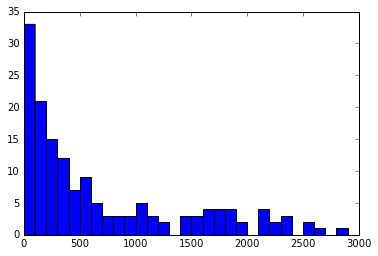

In [21]:
# distribution des tailles
duration = [v['duration'] for v in words.itervalues()]
plt.hist(duration,bins=range(0,3000,100));

In [22]:
from time import sleep
for i in range(10):
    random_k = random.choice(words.keys())
    d = words[random_k]['duration']
    while d<1500:
        random_k = random.choice(words.keys())
        d = words[random_k]['duration']
        
    print(random_k)
    out(stream,words[random_k]['data'])
        
    

w_36
w_91
w_33
w_28
w_55
w_10
w_141
w_90
w_140
w_75


# écho

In [23]:
echo = npdata.copy()
delay = 4000
echo = np.pad(echo,delay*2,mode='constant',constant_values = 0)
for i in range(echo.size-delay):
    echo[i+delay-1] += echo[i]/3. 

In [24]:
out(stream,echo)

# Thank you

In [25]:
v = np.append(words['w_00']['data'],words['w_01']['data'])
out(stream,v)

In [26]:
stream.stop_stream()
stream.close()